In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
sys.path.append('../../src/')
# import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

In [14]:
# Stationary Block Bootstrap 2.7.2 of Lahiri

def SB(X, p, N):
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # N: number of SB samples
     
    I = np.random.choice(len(X), N, replace=True)
    L = np.random.geometric(p=p, size=N)
    L[L<=20] = 20
    
    X_repeat = np.repeat(X, np.floor(np.max(L)/len(X))+1, axis=0)
#     print(np.mean(L))
    samples = []
    for i in range(len(I)):
        s = X_repeat[I[i]: I[i]+L[i]]
        samples.append(s)
    
    return samples

In [15]:
# def plot_compare_assets_across_risk_measures(risk_fn):
#     factor = 4
#     xsize = len(risk_measures)*factor
#     ysize = 1*factor

#     fig, axs = plt.subplots(1,len(risk_measures), figsize=(xsize, ysize), sharey=True)

#     for p, rm in enumerate(risk_measures):
#         HE_outer = []
#         for q, rn in enumerate(order):
#             if rm != 'CH':
#                 path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
#                 %(rn, rm)
#             else:
#                 path = '../../results/%s/MM/rh_cross_hedge.csv'\
#                 %(rn)    
#             _df = pd.read_csv(path)

#             B_rs = make_blocks(_df.rs, 1, 100)
#             B_rh = make_blocks(_df.rh, 1, 100)
#             _id = np.random.choice(range(len(B_rs)), 500 , replace=True)

#             HE = []
#             for i in _id:
#                 rho_rs = risk_fn(B_rs[i])
#                 rho_rh = risk_fn(B_rh[i])
#                 HE.append(1-rho_rh/rho_rs)
#             HE_outer.append(HE)

#         axs[p].boxplot(HE_outer)
#         axs[p].set_title(rm)

#     plt.tight_layout()
#     for p, a in enumerate(axs):
#         xtickNames = plt.setp(axs[p], xticklabels=coin_names)
#         plt.setp(xtickNames, rotation=90, fontsize=8)


In [16]:
def plot_compare_assets_across_risk_measures(risk_fn, SB_p, SB_N):
    factor = 4
    xsize = len(risk_measures)*factor
    ysize = 1*factor

    fig, axs = plt.subplots(1,len(risk_measures), figsize=(xsize, ysize), sharey=True)

    for p, rm in enumerate(risk_measures):
        HE_outer = []
        for q, rn in enumerate(order):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)

        axs[p].boxplot(HE_outer, showfliers=False)
        axs[p].set_title(rm)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=coin_names)
        plt.setp(xtickNames, rotation=90, fontsize=8)


In [17]:
def plot_compare_risk_measures_across_assets(risk_fn, SB_p, SB_N):
    factor = 4
    xsize = len(order)*factor
    ysize = 1*factor

    fig, axs = plt.subplots(1,len(order), figsize=(xsize, ysize), sharey=False)

    for p, rn in enumerate(order):
        HE_outer = []
        for q, rm in enumerate(risk_measures):
            if rm != 'CH':
                path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = '../../results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)

        axs[p].boxplot(HE_outer, showfliers=False)
        axs[p].set_title(rn)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=risk_measures)
        plt.setp(xtickNames, rotation=90, fontsize=8)


In [18]:
# # moving block bootstrapping (MBB) p. 26 of Lahiri

# def make_blocks(r, step_size, block_size):
#     b = []
#     for i in range(0,len(r), step_size):
#         if i+block_size >= len(r):
#             break
#         b.append(r[i:i+block_size])
#     return b

In [19]:
# def plot_compare_risk_measures_across_assets(risk_fn):
#     factor = 4
#     xsize = len(order)*factor
#     ysize = 1*factor

#     fig, axs = plt.subplots(1,len(order), figsize=(xsize, ysize), sharey=False)

#     for p, rn in enumerate(order):
#         HE_outer = []
#         for q, rm in enumerate(risk_measures):
#             if rm != 'CH':
#                 path = '../../results/%s/MM/rh_%s_copula_selection.csv'\
#                 %(rn, rm)
#             else:
#                 path = '../../results/%s/MM/rh_cross_hedge.csv'\
#                 %(rn)    
#             _df = pd.read_csv(path)

#             B_rs = make_blocks(_df.rs, 1, 100)
#             B_rh = make_blocks(_df.rh, 1, 100)
#             _id = np.random.choice(range(len(B_rs)), 500 , replace=True)

#             HE = []
#             for i in _id:
#                 rho_rs = risk_fn(B_rs[i])
#                 rho_rh = risk_fn(B_rh[i])
#                 HE.append(1-rho_rh/rho_rs)
#             HE_outer.append(HE)

#         axs[p].boxplot(HE_outer)
#         axs[p].set_title(rn)

#     plt.tight_layout()
#     for p, a in enumerate(axs):
#         xtickNames = plt.setp(axs[p], xticklabels=risk_measures)
#         plt.setp(xtickNames, rotation=90, fontsize=8)

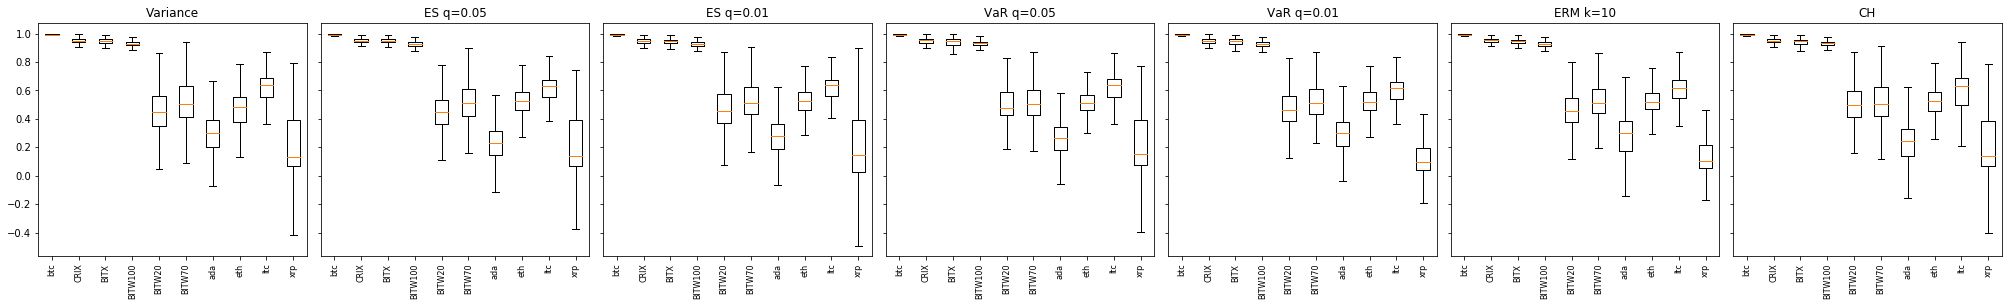

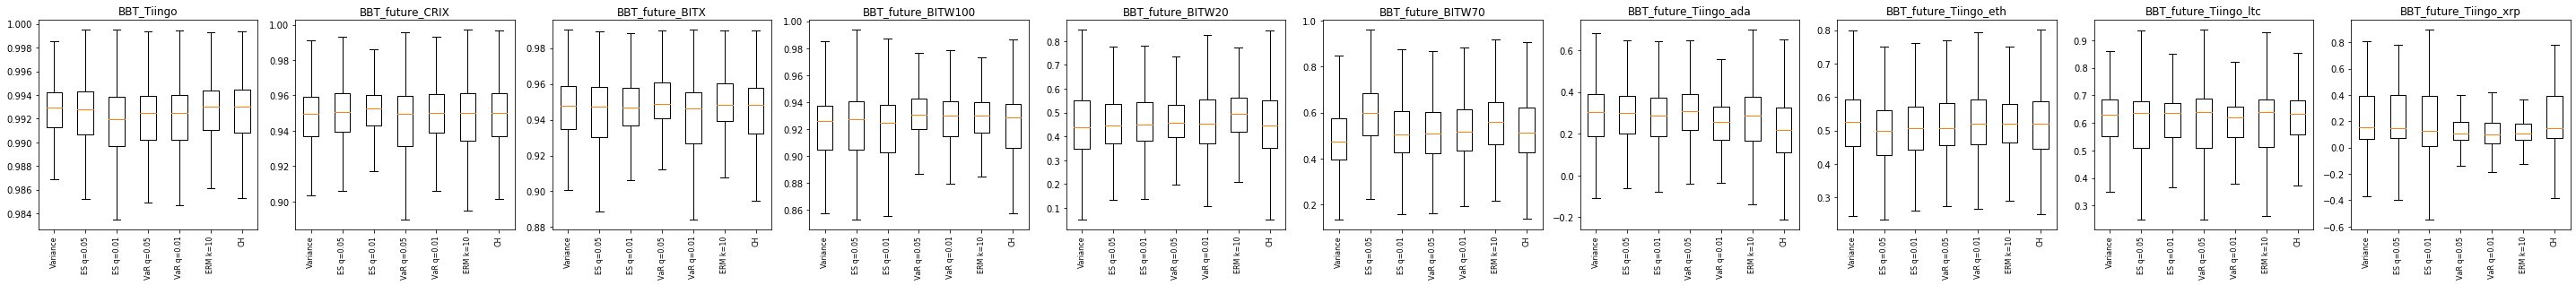

In [29]:
# Variance
risk_fn = np.var
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

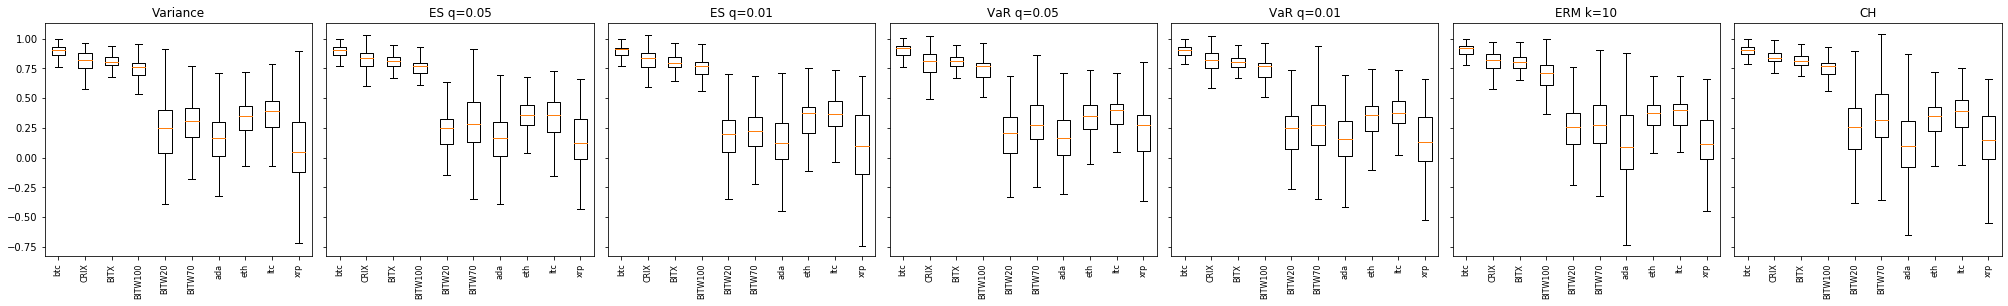

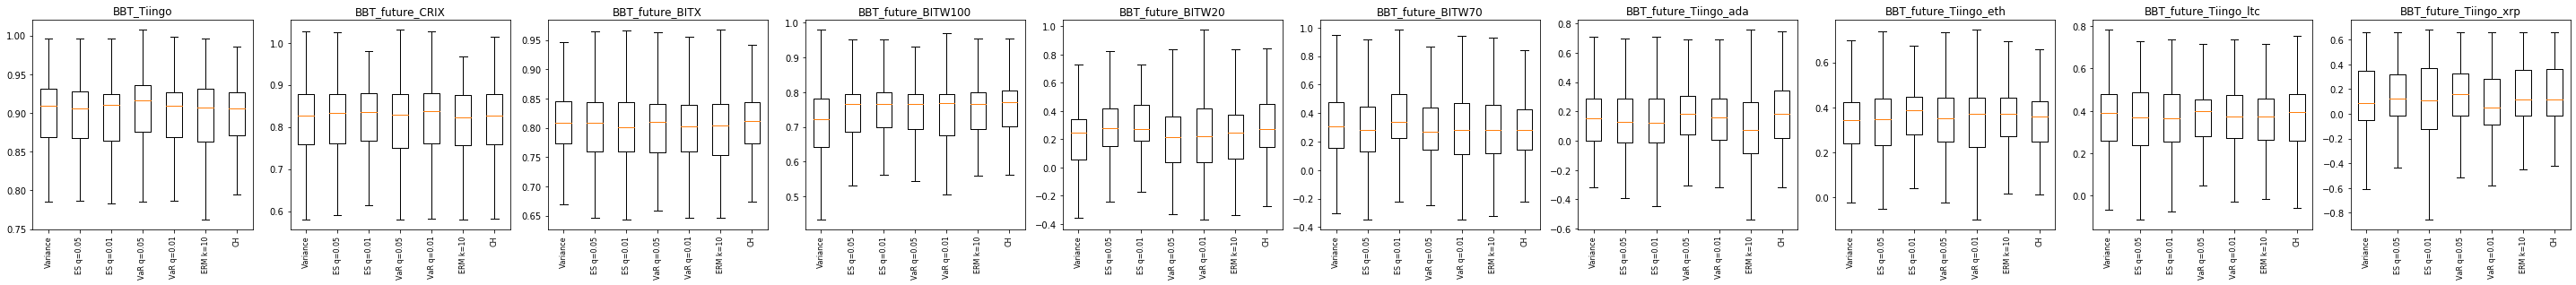

In [28]:
# Value at Risk 5%
risk_fn = lambda x: VaR(0.05, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

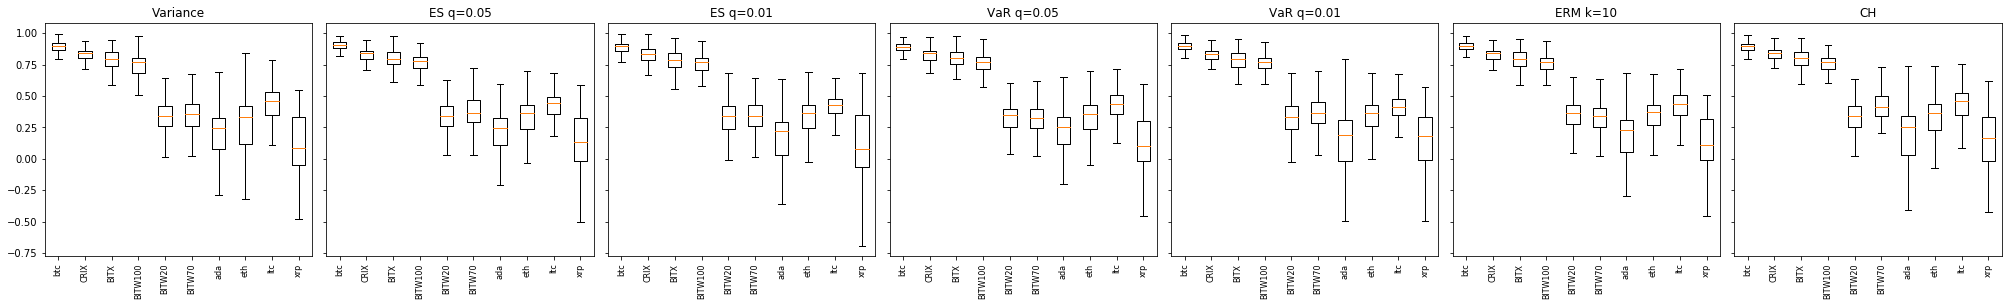

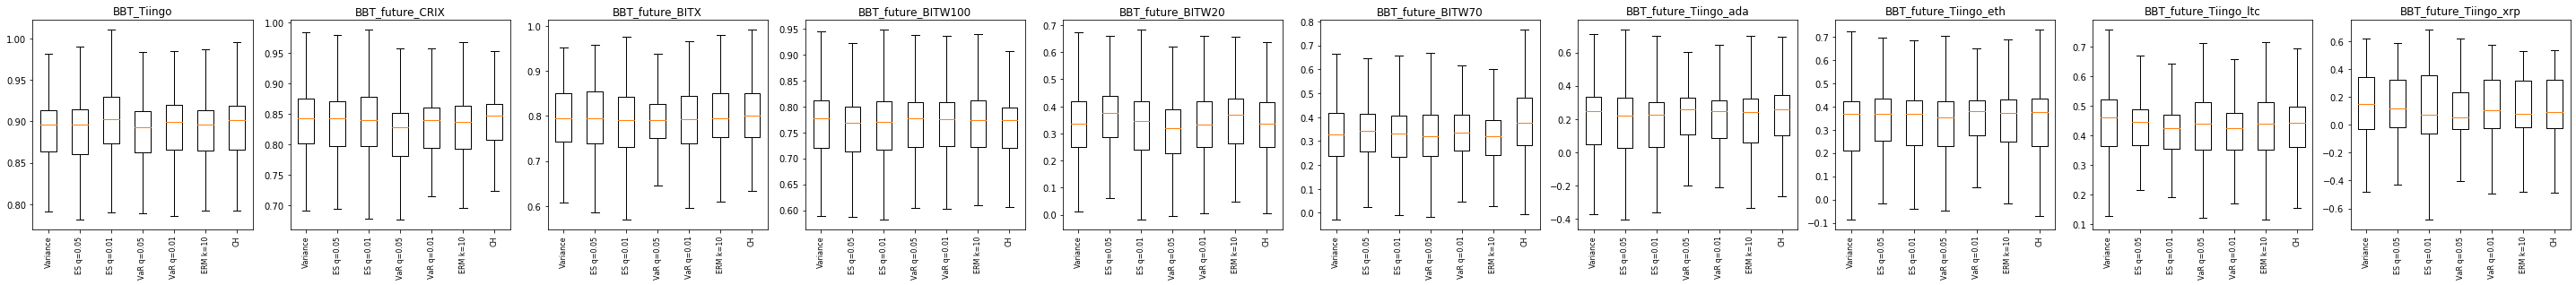

In [27]:
# Expected Shortfall 5%
risk_fn = lambda x: ES(0.05, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

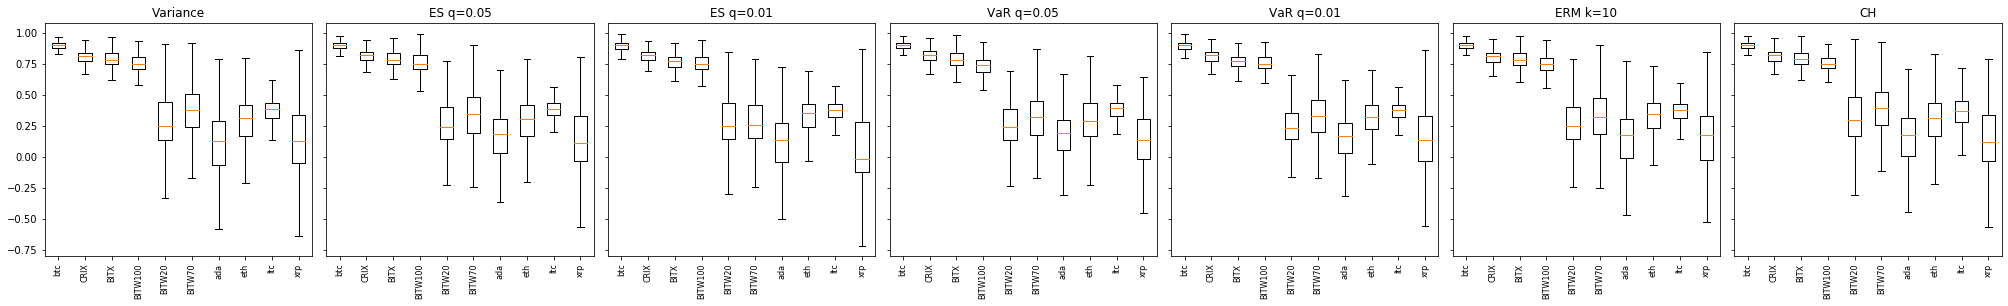

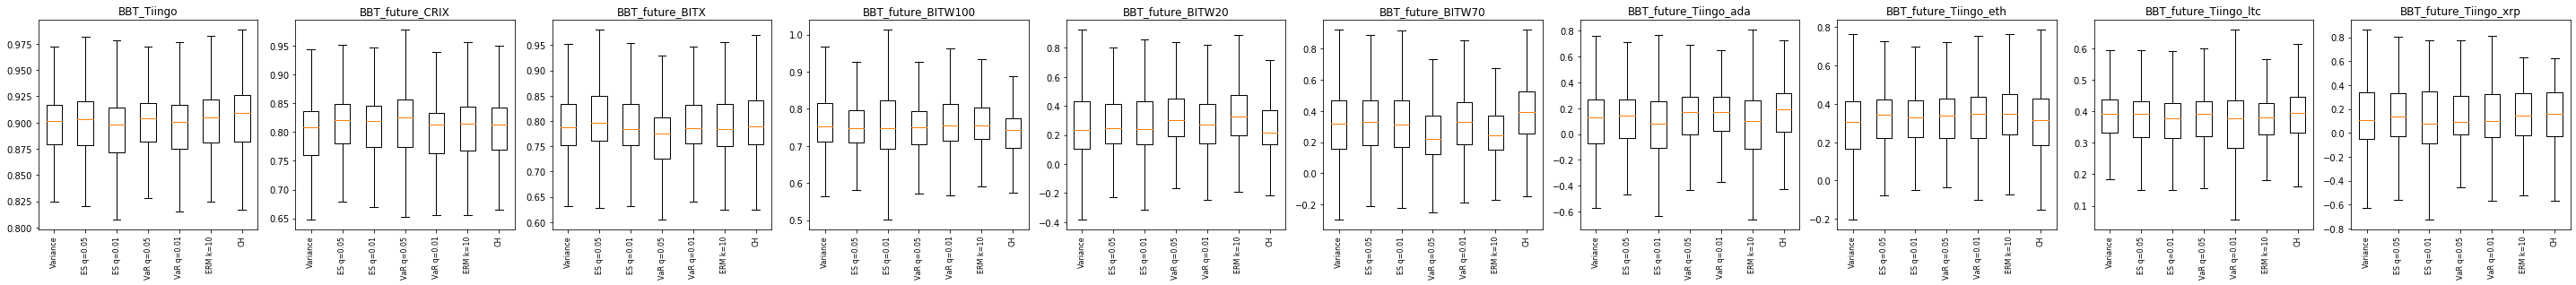

In [25]:
# ERM k=10
risk_fn = lambda x: ERM_estimate_trapezoidal(10, x)
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

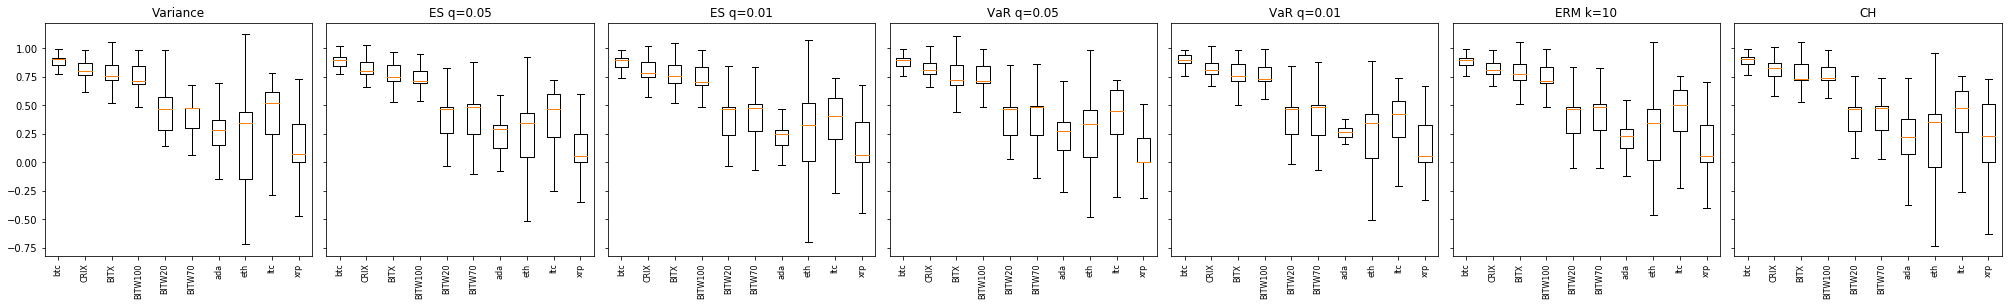

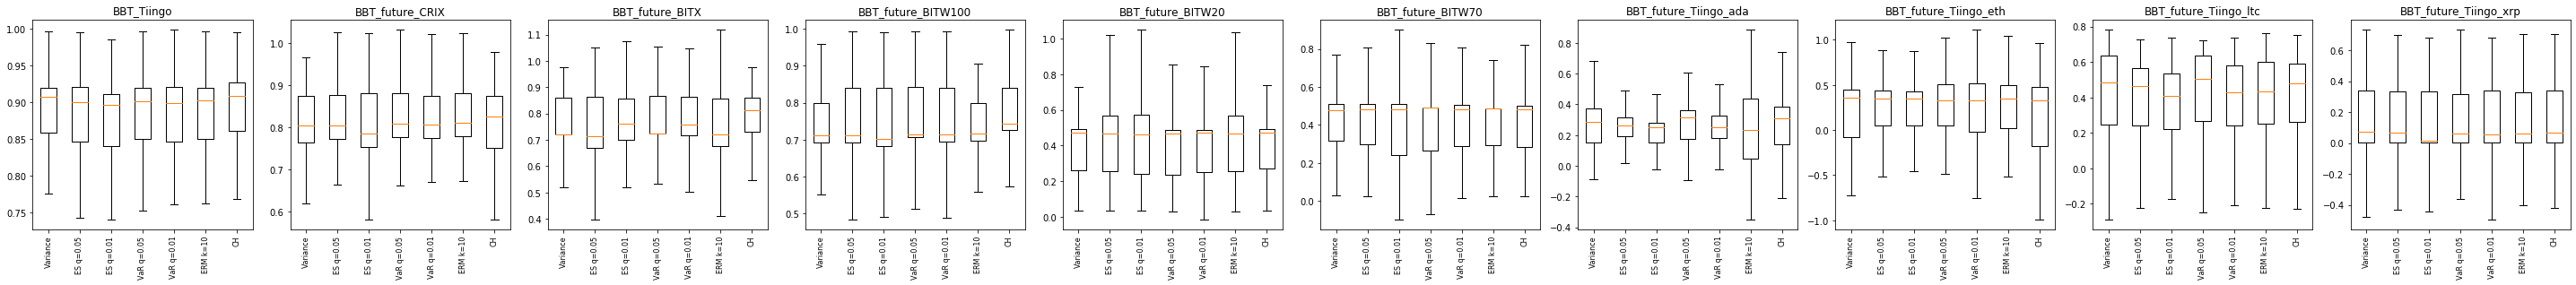

In [26]:
# Maximum Drawdown
risk_fn = np.min
plot_compare_assets_across_risk_measures(risk_fn, 1/200, 1000)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 1000)

In [471]:
risk_outer = []

N = 100

p = 1/200

# risk_fn = lambda x: ERM_estimate_trapezoidal(10, x)

risk_fn = lambda x: ES(0.05, x)

for rn in order[0:1]:

    path = '../../results/%s/MM/rh_cross_hedge.csv'\
                    %(rn)    
    _df = pd.read_csv(path)

    samples = SB(np.array(_df.loc[:,['rh', 'rs']]), p, N)

    risk = []

    for s in samples:
        risk_rh = risk_fn(s[:,0])
        risk_rs = risk_fn(s[:,1])
        risk.append(1-risk_rh/risk_rs)
        print(risk_rh, risk_rs, len(s))


    risk = np.array(risk)
    
    risk_outer.append(risk)
    print(rn)

0.00950141951046761 0.11635330247590134 121
0.006831433535822273 0.12097827698279305 74
0.007721681676627223 0.07204369115266775 185
0.012038010898095856 0.0619513080748815 71
0.01049704007874768 0.11345996552040194 178
0.009476832988635053 0.08527045663800228 378
0.002566798473162057 0.0600293139003604 17
0.008649570450508065 0.04583934871103187 117
0.0025527352768377944 0.0642537782044449 8
0.006079357573724787 0.07717211169749069 163
0.009281429022363095 0.09763271973994281 253
0.009185503355364132 0.05359062401074457 105
0.00890729950195305 0.11637777180099884 317
0.014155733910051952 0.1018866176984044 32
0.0015735656605358336 0.013196169962525 5
0.007730947562595001 0.11283398356466444 416
0.009320812825108177 0.0926480179994272 290
0.0027743835341000195 0.1185061713452199 12
0.00499207493953643 0.07977933287226986 97
0.01121000160380177 0.11886552175169396 112
0.008562046081793331 0.05732621052519582 157
0.0052938402211383 0.060440228573264546 72
0.008075098531929632 0.058052585

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > s

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.ty

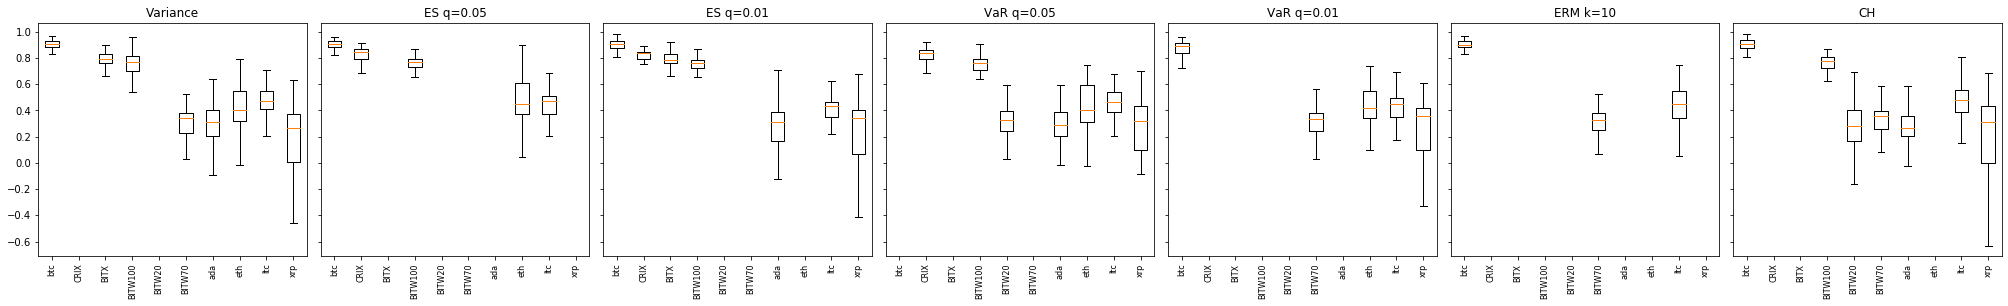

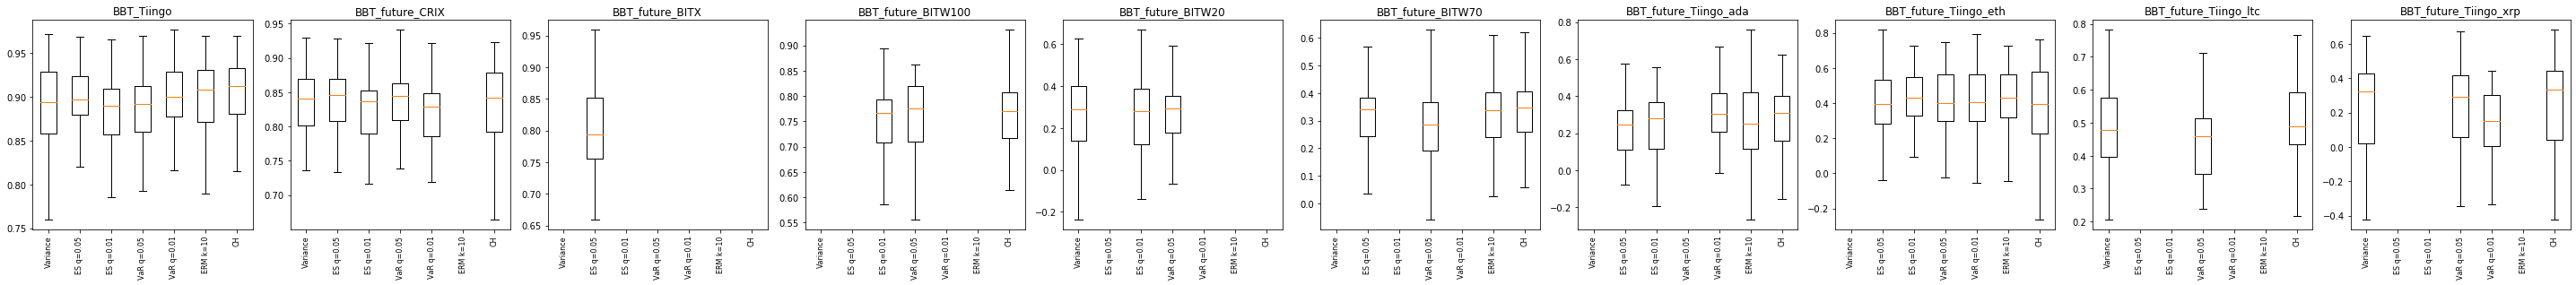

In [463]:
risk_fn = lambda x: ES(0.05, x)

plot_compare_assets_across_risk_measures(risk_fn, 1/200, 100)
plot_compare_risk_measures_across_assets(risk_fn, 1/200, 100)

In [432]:
rn = 'BBT_future_CRIX'

path = '../../results/%s/MM/rh_cross_hedge.csv'\
%(rn)    
_df = pd.read_csv(path)

In [437]:
np.sort(_df.rh[:100])

array([-0.07110023, -0.02645852, -0.02548743, -0.01724512, -0.01549379,
       -0.01387164, -0.01079779, -0.00990608, -0.0092026 , -0.00908369,
       -0.0090537 , -0.00848699, -0.00797213, -0.00780911, -0.00772059,
       -0.00764888, -0.00681136, -0.0065075 , -0.00624978, -0.00595099,
       -0.00587723, -0.0058324 , -0.00498369, -0.00408244, -0.0039405 ,
       -0.00379528, -0.00319549, -0.00262615, -0.00259962, -0.00223548,
       -0.00152227, -0.00132332, -0.0009565 , -0.00087404, -0.00076249,
       -0.00059055, -0.0004662 ,  0.00085108,  0.00102116,  0.00103057,
        0.00120041,  0.00123035,  0.00128512,  0.00162582,  0.00168708,
        0.00178662,  0.00179398,  0.00189474,  0.00209925,  0.00214898,
        0.00227868,  0.00229803,  0.00248716,  0.00272711,  0.00278911,
        0.0035585 ,  0.00456326,  0.00463358,  0.00491951,  0.00505375,
        0.00547431,  0.00576431,  0.00587913,  0.00618914,  0.00669647,
        0.00708937,  0.00733112,  0.00741768,  0.00763515,  0.00